CNN

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")


ModuleNotFoundError: No module named 'google.colab'

In [2]:
path = "/content/gdrive/MyDrive/car_detecction/datasets/captures_vehicle_ classification"

In [3]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Clasificador de imágenes

In [19]:
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline





Configuración de parámetros

In [2]:
width_shape = 224
height_shape = 224
num_classes = 3
epochs = 50
batch_size = 32 

Path de dataset

In [3]:
train_data_dir = "/content/gdrive/MyDrive/car_detecction/datasets/captures_vehicle_ classification/train"
validation_data_dir = "/content/gdrive/MyDrive/car_detecction/datasets/captures_vehicle_ classification/test"
#train_data_dir = "datasets/captures_vehicle_ classification/train"
#validation_data_dir = "datasets/captures_vehicle_ classification/test"

In [4]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 830 images belonging to 3 classes.
Found 278 images belonging to 3 classes.


Entrenamiento de modelo CNN

In [6]:
nb_train_samples = 206
nb_validation_samples = 58

#Creación de modelo 
model = Sequential()

inputShape = (height_shape, width_shape, 3)
model.add(Conv2D(32,(3,3), input_shape=inputShape))
model.add(Conv2D(32,(3,3)))
model.add(MaxPool2D())
          
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(num_classes,activation='softmax', name='output'))

model.summary()




Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import datetime 

# Checkpoint callback
checkpoint = ModelCheckpoint("nn_model_vgg_19.h5", save_best_only=True)

# Early stop callback
#early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [8]:
# Define all callbacks in a list
callbacks =[
    checkpoint,
    #early_stop
]

In [9]:
# Definimos los parametros de entrenamiento
params = {
    "validation_split": 0.2,
    "epochs": 10, 
    "callbacks": callbacks,
    "batch_size":32,
}

In [10]:
custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'] )

In [19]:
model_history = custom_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size,
    callbacks = callbacks)


Epoch 1/50


KeyboardInterrupt: 

Grabar modelo en disco

In [14]:
custom_model.save("model_VGG16.h5")

Cargar un modelo entrenado

In [13]:
from tensorflow.keras.models import load_model
model_history = load_model("nn_model_vgg_19_v2_200.h5")

Gráficas de entrenamiento y validación (accuracy - loss)

In [14]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=18)
    plt.grid(True)

In [15]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

TypeError: 'NoneType' object is not subscriptable

<Figure size 1000x500 with 0 Axes>

Prediccion y acurracy

Predicción usando el modelo entrenado

1/1 [==============================] - 1s 668ms/step
bus


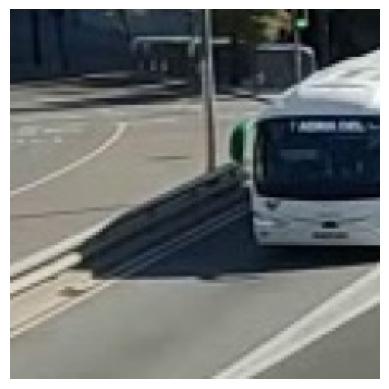

In [20]:
names = ['bus', 'car', 'truck']

modelt = load_model("nn_model_vgg_19.h5")
#modelt = custom_vgg_model

imaget_path = "datasets/captures_vehicle_ classification/test/bus/vehicle_473.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Matriz de confusión y métricas de desempeño

Found 278 images belonging to 3 classes.


C:\Users\luism\AppData\Local\Temp\ipykernel_20168\1374132354.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator)


              precision    recall  f1-score   support

           0     0.8000    0.5275    0.6358        91
           1     0.7128    0.7053    0.7090        95
           2     0.5726    0.7717    0.6574        92

    accuracy                         0.6691       278
   macro avg     0.6951    0.6682    0.6674       278
weighted avg     0.6949    0.6691    0.6680       278



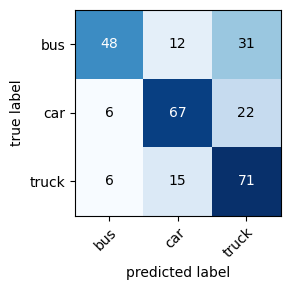

In [21]:
names = ['bus', 'car', 'truck']

test_data_dir = "datasets/captures_vehicle_ classification/test"  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("nn_model_vgg_19_v2_200.h5")

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(3,3), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))